<h1> DAY 2: Approximate Reinforcement Learning </h1>
<p> <img src="http://skyai.org/wiki/?plugin=attach&refer=Documentation%2FTutorial%20-%20Example%20-%20Mountain%20Car&openfile=mountaincar.png" alt="picture of the mountain-car environment" style="float:right;width:500px;border:10px solid #FFFFFF;">
<h3> MountainCar </h3>
<p> A car starts in a valley between two mountains, as depicted in the image to the right. The car must reach the goal location on the top of the right mountain by using three possible actions: accelerate forwards, backwards or doing nothing. However, the car's motor is underactuated and cannot drive straight uphill. The agent's task is to find a policy that swings the car back and forth such that it eventually reaches the goal position. </p>
<p> The state space contains the continuous position of the car in [-1.2, 0.6] and its continuous velocity in [-0.07, 0.07]. The reward is 0 for reaching the goal and -1 for each other step. Episodes end after reaching the goal or 1000 steps otherwise (this is a deviation from the classical task). </p>
</p>

# EXERCISE 1: Tabular Q-learning
In this exercise, you will familiarise yourself with a given agent class and an experiment script that runs OpenAI Gym environments.

In the following code block, we define a longer Mountain-Car environment from the OpenAI Gym.
Note that some installed libraries may throw some warnings here. Ignore them unless task 1c does not work.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gym
import torch
#import torch.nn as nn
#import torch.nn.functional as F
import random
from math import e as nate

def make_environment():
    """ Returns a new mountain-car environment. """
    # Register special version of MountainCar with long episodes
    gym.envs.register(
        id='MountainCarExtraLong-v0',
        entry_point='gym.envs.classic_control:MountainCarEnv',
        max_episode_steps=1000,
        reward_threshold=-110.0,
    )
    # Create environment
    env = gym.make('MountainCarExtraLong-v0')
    env_name = 'MountainCarExtraLong-v0'
    env = gym.make(env_name)
    # Set seeds (for reproduceability)
    env.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    return env

# Make a mountain-car environment
env = make_environment()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/usr/local/lib/python3.5/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## TASK 1a: the agent 
Familiarise yourself with the below specification of a QLearner at the example of the following Tabular Q-Learner. 
Given the action to execute, gym environments return the next state, the received reward and a Boolean done, which indicated that the episode has ended.

Complete the update() function of the TabularQLearner by filling in the TD-error for Q-learning. Make sure that the value of the next state is 0 for the last step of an episode, that is, when done=True.

In [2]:
class QLearner:
    """ Specifies a RL agent that can compute Q-values. """
    gamma = 0.9    # discount factor
    name = None    # the name of this agent (for the legend in plots)
    epsilon = 0.1  # the exploration parameter for epsilon-greedy
    
    def q_values(self, state):
        """ Returns the estimated Q-values (as a np.ndarray) of the given state. """
        assert False, "Abstract class must be inherited from to get Q-values."

    def sample(self, state):
        """ Returns a greedily sampled action according to the estimated Q-values of the given state. """
        assert False, "Abstract class must be inherited from to sample."

    def update(self, state, action, reward, next_state, done):
        """ Updates the Q-value estimate after observing a transition from 'state', using 'action',
            receiving 'reward' and ending up in 'next_state'. The Boolean 'done' indicates whether
            or not the episode has ended with this transition. Returns nothing. """
        assert False, "Abstract class must be inherited from to update."
    
    def get_epsilon(self):
        """ Returns the exploration parameter of epsilon-greedy. """
        return self.epsilon
    
    def set_epsilon(self, iter):
        """ Can be overwritten to change the exploration parameter during training. """
        pass


class TabularQLearner (QLearner):
    """ Tabular Q-learning agent. """
    learn_rate = 0.1    # learning rate of the Q-learning update
    n_states = 40       # number of states per state-dimension
    q_table = None      # table with Q-values
    env_low = None
    env_dx = None

    def __init__(self, env, n_states=None):
        """ Creates a tabular Q-learning agent with n_states in each of teh env(ironments) state directions. """
        self.name = "Tabular (%u states)" % (n_states ** 2)
        if n_states is not None:
            self.n_states = n_states
        self.env_low = env.observation_space.low
        self.env_dx = (env.observation_space.high - self.env_low) / (self.n_states - 1)
        self.q_table = np.zeros((self.n_states, self.n_states, env.action_space.n))

    def _state_to_index(self, obs):
        """ Maps an observed state to an index of the q_table. """
        a = int((obs[0] - self.env_low[0]) / self.env_dx[0])
        b = int((obs[1] - self.env_low[1]) / self.env_dx[1])
        return a, b

    def q_values(self, state):
        """ Returns the estimated Q-values (as a np.ndarray) of the given state. """
        a, b = self._state_to_index(state)
        return self.q_table[a][b]

    def sample(self, state):
        """ Returns a greedily sampled action according to the estimated Q-values of the given state. """
        return np.argmax(self.q_values(state))

    def update(self, state, action, reward, next_state, done):
        """ The agent 'learns' from the given transition. """
        not_done = 0 if done else 1
        a, b = self._state_to_index(state)
        a_, b_ = self._state_to_index(next_state)
        # Update Q-table with the TD-error for Q-learning (fill in to complete class)
        td_error = reward + not_done * self.gamma * np.max(self.q_table[a_][b_]) - self.q_table[a][b][action]
        self.q_table[a][b][action] = self.q_table[a][b][action] + self.learn_rate * td_error

The following code-block contains a plotting function that keeps track of the experimental results. Re-executing this block, or calling clear_plots(), will clear all previous experiments from future plots; otherwise the specifics of the code block can be ignored (but has to be exectuted) for the exercise.

In [3]:
def clear_plots():
    """ Clears the plot buffers from previous experimental results"""
    global last_agent, plot_rewards, plot_labels
    last_agent = None
    plot_rewards = []
    plot_labels = []

def compute_q_values(env):
    """ Computes the Q-values on an equidistant grid. """
    dim = 100    # resolution of the resulting image
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    # Create the states
    states = np.zeros((2, dim ** 2))
    states[0, :] = np.tile(np.linspace(env_low[0], env_high[0], num=dim), dim)
    states[1, :] = np.repeat(np.linspace(env_high[1], env_low[1], num=dim), dim)
    q_values = np.zeros((3, dim ** 2))
    for i in range(dim ** 2):
        q = last_agent.q_values(states[:, i])
        q_values[:, i] = q.detach().cpu().numpy() if isinstance(q, torch.Tensor) else q
    return q_values

def compute_trajectory(env, agent):
    """ Returns a trajectory (as np.ndarray) in the given env(ironment) executed by the given agent. """
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    state = env.reset()
    traj = [(state - env_low) / (env_high - env_low)]
    done = False
    while(not done):
        action = agent.sample(state)
        state, _, done, _ = env.step(action)
        traj.append((state - env_low) / (env_high - env_low))
    return np.stack(traj, axis=1)

def plot_as_image(ax, env, values):
    """ Plots a given np.ndarray of values as a sqare image in the given ax(es). """
    dim = int(np.sqrt(len(values)))
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    cax = ax.imshow(values.reshape((dim, dim)), extent=[0, 1, 0, 1], cmap='jet')
    ax.set_xlabel('Car Position')
    ax.set_xticklabels(["%g" % (env_low[0] + i * (env_high[0] - env_low[0]) / 5) for i in range(6)])
    ax.set_ylabel('Car Velocity')
    ax.set_yticklabels(["%g" % (env_low[1] + i * (env_high[1] - env_low[1]) / 5) for i in range(6)])
    return plt.gcf().colorbar(cax, ax=ax)

def plot_all_results(env, plot_std=True):
    """ Plots the performance of all experiments in the result-buffers, as well as the value function/policy 
        of the agent at the end of the last experiment. """
    colors = ['orange', 'red', 'magenta', 'blue', 'green', 'black', 'c', 'y', 'lime']
    # Generate figure and subplot grid
    gs = matplotlib.gridspec.GridSpec(2, 5)
    ax1 = plt.subplot(gs[:, :3])
    ax2 = plt.subplot(gs[0, 3:])
    ax3 = plt.subplot(gs[1, 3:])
    plt.gcf().set_size_inches([16, 7.5])
    # Plot the performance
    if plot_std:
        # Make a nice plot with mean and standard deviation for every 10 samples
        for i in range(len(plot_rewards)):
            rew = np.array(plot_rewards[i])
            rew = rew[:(len(rew) - len(rew) % 10)].reshape(int(len(plot_rewards[i]) / 10), 10)
            m = np.mean(rew, axis=1)
            s = np.std(rew, axis=1)
            x = np.linspace(5, 10 * len(m) + 5, len(m))
            ax1.fill_between(x=x, y1=m - s, y2=m + s, alpha=0.2, linewidth=0, facecolor=colors[i % len(colors)])
            ax1.plot(x, m, color=colors[i % len(colors)])
        ax1.set_xlabel("Environmental Steps")
        ax1.set_ylabel("Episode Reward (STD)")
        ax1.set_ylim(-1000, 0)
        ax1.set_xlim(0, len(plot_rewards[0]))
    else:
        # Use an ugly plot that plots every single measurement
        for rewards in plot_rewards:
            ax1.plot(rewards)
        ax1.set_xlabel("Epsiodes")
        ax1.set_ylabel("Episode Reward")
    ax1.legend(plot_labels, loc='lower right')
    # Generate Q-values and example trajectories
    traj_list = [compute_trajectory(env, last_agent) for _ in range(3)]
    colors = ['darkgrey', 'lightgrey', 'white']
    q_values = compute_q_values(env)
    # Plot the value function
    plot_as_image(ax2, env, q_values.max(axis=0))
    for i, traj in enumerate(traj_list):
        ax2.plot(traj[0, :], traj[1, :], color=colors[i % len(colors)])
    ax2.set_xlabel('')
    ax2.set_title('Value Function & Greedy Policy')
    # Plot the policy
    cbar = plot_as_image(ax3, env, q_values.argmax(axis=0))
    for traj in traj_list:
         ax3.plot(traj[0, :], traj[1, :], color=colors[i % len(colors)])
    cbar.set_ticks([0, 1, 2])
    cbar.ax.set_yticklabels(['-acc', '0', '+acc'])
    plt.show()
    
clear_plots()

## TASK 1b: the experiment 
Familiarize yourself with the basic loop of the RL experiment.

In [45]:
def run_experiment(env, agent: QLearner, num_episodes=1000):
    iter_max = num_episodes     # number of episodes
    # Set seeds (for reproduceability)
    env.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    # Initialise the result lists
    total_reward_list = []
    total_steps = 0
    print('----- Start Learning with %s Q-learning -----' % agent.name)
    # For iter_max episodes
    for iter in range(iter_max):
        # Reset the episode
        state = env.reset()
        total_reward = 0
        done = False
        # Run the episode until it is done (as signaled by the environment)
        while not done:
            current_state = state
            # Epsilon greedy action selection
            if np.random.uniform(0, 1) < agent.get_epsilon():
                # Random choice
                action = np.random.choice(env.action_space.n)
            else:
                # Greedy choice
                action = agent.sample(current_state)
            # One environmental step
            state, reward, done, _ = env.step(action)
            total_reward += reward
            # Update agent
            agent.update(current_state, action, reward, state, done)
            total_steps += 1
        total_reward_list.append(total_reward)
        agent.set_epsilon(iter)
        # Output for user (every 100 episodes)
        if iter % 100 == 49:
            print('Episode #%d (%u steps) -- Total reward = %g, epsilon=%g.' % 
                  (iter+1, total_steps, total_reward, agent.get_epsilon()))
    # Book keeping for the plotting script
    if agent.name in plot_labels:
        plot_rewards[plot_labels.index(agent.name)] = total_reward_list
    else:
        plot_labels.append(agent.name)
        plot_rewards.append(total_reward_list)
    global last_agent
    last_agent = agent

## TASK 1c: test the tabular agent 
Run the above experiment with a TabularQLearner, which uses a discretization of 40 states per dimension.

----- Start Learning with Tabular (1600 states) Q-learning -----
Episode #50 (50000 steps) -- Total reward = -1000, epsilon=0.1.
Episode #150 (145141 steps) -- Total reward = -1000, epsilon=0.1.
Episode #250 (221519 steps) -- Total reward = -641, epsilon=0.1.
Episode #350 (285685 steps) -- Total reward = -597, epsilon=0.1.
Episode #450 (339672 steps) -- Total reward = -539, epsilon=0.1.
Episode #550 (388301 steps) -- Total reward = -870, epsilon=0.1.
Episode #650 (439351 steps) -- Total reward = -316, epsilon=0.1.
Episode #750 (481904 steps) -- Total reward = -430, epsilon=0.1.
Episode #850 (524196 steps) -- Total reward = -386, epsilon=0.1.
Episode #950 (559881 steps) -- Total reward = -416, epsilon=0.1.


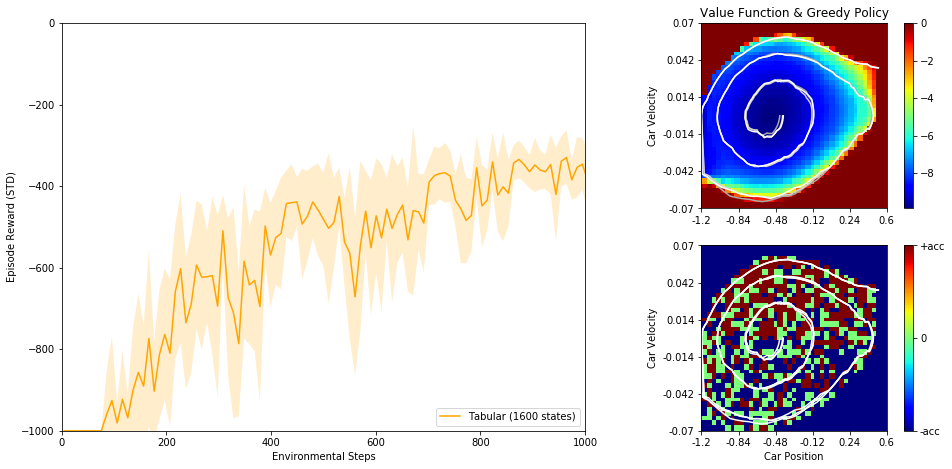

In [5]:
run_experiment(env, TabularQLearner(env, 40))
plot_all_results(env)

Discuss the resulting performance, value function and policy with your neighbours. Do you see a consistent behaviour policy, and if not, why?

# EXERCISE 2: Approximate Q-learning
In this exercise you will implement a QLearner based on gradient descend with a linear Q-value function.


## TASK 2a: basis functions
Now we want to use approximate Q-learning for linear functions. Familiarize yourself with our specification of basis functions.

In [6]:
class BasisFunctions:
    """ Abstract class that specifies basis functions. """
    name = None                  # the name of the basis function
    num_features = None          # the number of basis functions
    _env_low = None
    _env_high = None
    _env_dx = None

    def __init__(self, env):
        self._env_low = env.observation_space.low
        self._env_high = env.observation_space.high
        self._env_dx = self._env_high - self._env_low

    def __call__(self, state):
        """ Returns the basis function outputs of the given state as a vector.  """
        assert False, "Abstract class must be inherited from to call."

    def new_weights(self):
        """ Returns a newly initialized fitting weight vector. """
        return np.zeros(self.num_features)

class OneHot (BasisFunctions):
    """ one-hot encoding of 2d-spaces """
    n_states = None

    def __init__(self, env, n_states):
        """ Creates a one-hot encoding with n_states discrete intervals in each input dimension. """
        BasisFunctions.__init__(self, env)
        self.name = "OneHot"
        self.n_states = n_states
        self.num_features = n_states ** 2

    def __call__(self, state):
        """ Overrides the () operator and returns a one-hot encoding of the given state."""
        phi = np.zeros(self.num_features)
        index = np.floor((state - self._env_low) / self._env_dx * (self.n_states-1))
        phi[int(index[0] * self.n_states + index[1])] = 1
        return phi

class RBF (BasisFunctions):
    """ Exponential radial basis functions in 2d spaces."""
    normalize = True      # this flag normalizes the L_1 norm of the output vector to 1
    centers = None
    sigmas = None

    def __init__(self, env, n_bases):
        """ Creates a set of equidistant basis functions with n_bases functions in each input dimension. """
        BasisFunctions.__init__(self, env)
        self.name = "RBF"
        self.num_features = n_bases ** 2
        self._make_centers(n_bases)
    
    def _make_centers(self, n_bases):
        """ Initializes the centers of the RBF basis functions as an equidistant grid 
            and width sigma as the distance between the centers to guarantee enough overlap. """
        # Create centers of the RBF
        self.centers = np.zeros((2, n_bases ** 2))
        self.centers[0, :] = np.repeat(np.linspace(self._env_low[0], self._env_high[0], num=n_bases), n_bases)
        self.centers[1, :] = np.tile(np.linspace(self._env_low[1], self._env_high[1], num=n_bases), n_bases)
        # Create widths of the RBF
        self.sigmas = np.zeros((2, n_bases ** 2))
        self.sigmas[0, :] = np.repeat(np.ones(n_bases) * self._env_dx[0] / (n_bases-1), n_bases)
        self.sigmas[1, :] = np.tile(np.ones(n_bases)  * self._env_dx[1] / (n_bases-1), n_bases)

    def __call__(self, state):
        """ Overrides the () operator and returns the (normalised) RBF output for the given state."""
        # Compute the RBFs
        phi = np.exp(- np.sum(((self.centers - np.expand_dims(state, axis=1)) / self.sigmas) ** 2, axis=0))
        # Optionally normalize the RBF output to sum 1
        if self.normalize:
            phi /= np.sum(phi, axis=0)
        # Return feature(s)
        return phi

## Task 2b: semi-gradients 
Derive the semi-gradient of the quadratic Bellman-error of Q-learning at time $t$ (i.e. after observing s_t, a_t, r_t and s_{t+1}) for a linear Q-function. Write down both the loss function and the semi-gradient as a LaTeX formula:

In [19]:
%%latex
The Q-value function is given by $Q(s,a) = \vec w^{a} \!\!\cdot \vec \phi(s)$.
\begin{eqnarray*} 
    \mathcal{L}_t &=& {\textstyle\frac{1}{2}} \Big( r_t 
                            + \gamma \max_{a'}\!\big\{ Q(s_{t+1}, a') \big\} 
                            - Q(s_t, a_t) \Big)^2
                    \;=\; {\textstyle\frac{1}{2}} \Big( r_t 
                            + \gamma \max_{a'}\!\big\{\vec w^{a'} \!\!\cdot \vec \phi(s_{t+1}) \big\} 
                            - \vec w^{a_t} \!\!\cdot \vec \phi(s_t) \Big)^2
\\[2mm]
    \frac{\partial \mathcal{L}_t}{\partial \vec w^{a}}  &=& 
            \left\{ \begin{array}{ll}
                                \big( r_t 
                                  + \gamma \max_{a'}\!\big\{ Q(s_{t+1}, a') \big\} 
                                  - Q(s_t, a_t) \big) \; \vec \phi(s_t)
                            & \text{if }a = a_t \\
                            \vec 0  &\text{if }a \neq a_t 
            \end{array}\right.
\end{eqnarray*}

<IPython.core.display.Latex object>

## TASK 2c: linear Q-functions 
Implement the corresponding semi-gradient QLearner in the below skeleton. Make sure that, similarly to task 1a, the end of the episode (done=True) is handled correctly.

In [8]:
class LinearQLearner (QLearner):
    learn_rate = 0.1
    basis = None
    weights = None

    def __init__(self, env, basis: BasisFunctions):
        self.name = "Linear (%u %s)" % (basis.num_features, basis.name)
        self.basis = basis
        self.weights = np.stack([basis.new_weights() for _ in range(env.action_space.n)], axis=0)

    def q_values(self, state):
        """ Returns the estimated Q-values (as a np.ndarray) of the given state. """
        return self.weights.dot(self.basis(state))

    def sample(self, state):
        """ Returns an action the agent has chosen at the given state. """
        return np.argmax(self.q_values(state))

    def update(self, state, action, reward, next_state, done):
        """ The agent 'learns' from the given transition. """
        not_done = 0 if done else 1
        td_error = reward + not_done * self.gamma * np.max(self.q_values(next_state)) - self.q_values(state)[action]
        self.weights[action, :] = self.weights[action, :] + self.learn_rate * td_error * self.basis(state)

## TASK 2d: approximation with one-hot bases 
Test your above implementation with one-hot basis functions (with 40 bases in each state-dimension). 

----- Start Learning with Linear (1600 OneHot) Q-learning -----
Episode #50 (50000 steps) -- Total reward = -1000, epsilon=0.1.
Episode #150 (145141 steps) -- Total reward = -1000, epsilon=0.1.
Episode #250 (221519 steps) -- Total reward = -641, epsilon=0.1.
Episode #350 (285685 steps) -- Total reward = -597, epsilon=0.1.
Episode #450 (339672 steps) -- Total reward = -539, epsilon=0.1.
Episode #550 (388301 steps) -- Total reward = -870, epsilon=0.1.
Episode #650 (439351 steps) -- Total reward = -316, epsilon=0.1.
Episode #750 (481904 steps) -- Total reward = -430, epsilon=0.1.
Episode #850 (524196 steps) -- Total reward = -386, epsilon=0.1.
Episode #950 (559881 steps) -- Total reward = -416, epsilon=0.1.


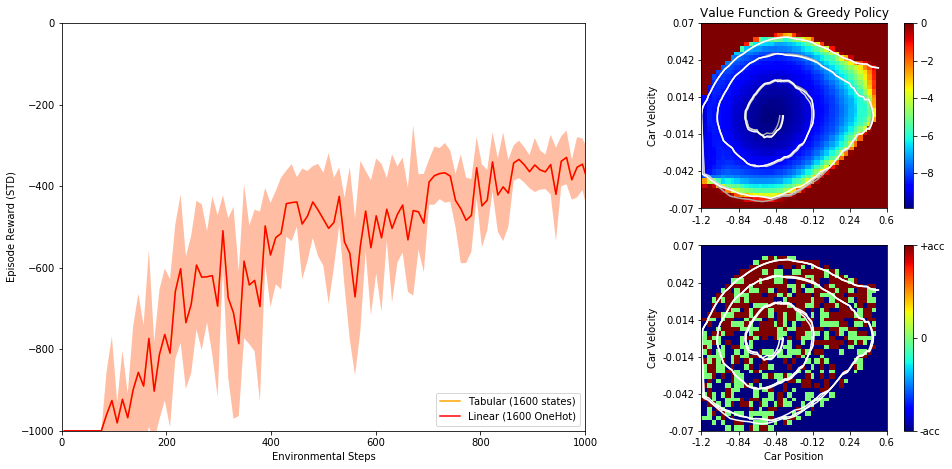

In [9]:
run_experiment(env, LinearQLearner(env, OneHot(env, 40)))
plot_all_results(env)

Gradient descent on one-hot vectors are equivalent to tabular Q-learning. Do your results mirror the performance of the TabularQLearner?

## Task 2e: approximation with RBF bases
Now test your LinearQLearner with the given RBF bases (15 centers for each state dimension). 

----- Start Learning with Linear (256 RBF) Q-learning -----
Episode #50 (44054 steps) -- Total reward = -583, epsilon=0.1.
Episode #150 (84002 steps) -- Total reward = -367, epsilon=0.1.
Episode #250 (111998 steps) -- Total reward = -288, epsilon=0.1.
Episode #350 (139107 steps) -- Total reward = -181, epsilon=0.1.
Episode #450 (222681 steps) -- Total reward = -1000, epsilon=0.1.
Episode #550 (322681 steps) -- Total reward = -1000, epsilon=0.1.
Episode #650 (422681 steps) -- Total reward = -1000, epsilon=0.1.
Episode #750 (522681 steps) -- Total reward = -1000, epsilon=0.1.
Episode #850 (622681 steps) -- Total reward = -1000, epsilon=0.1.
Episode #950 (722681 steps) -- Total reward = -1000, epsilon=0.1.


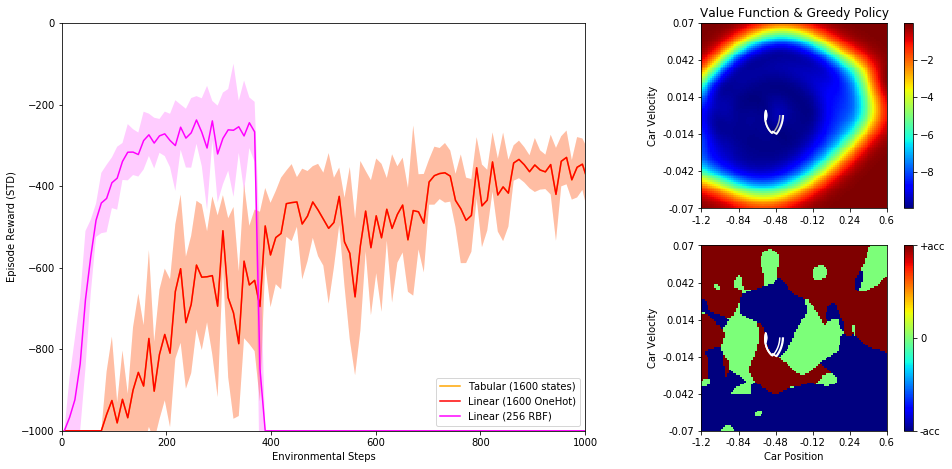

In [10]:
run_experiment(env, LinearQLearner(env, RBF(env, 16)))
plot_all_results(env)

Function approximation allows the agent to learn much faster, but the agent's performance can become extremly unstable in later episodes. This is somewhat surprising, as the lecture has established that semi-gradient TD(0) learning is supposed to converge in the linear case. Discuss with your neighbors why this is not the case here. If you want, change the number of episodes in run_experiment() to a value at which your algorithm is still stable and compare the resulting values/policies.

# EXERCISE 3: Stabilising Approximate Q-learning
Q-learning with semi-gradient descent is often unstable. In this exercise you will implement techniques that have emerged to stabilise approximate RL, namely Target Networks and Experience Replay Buffers.

## Task 3a: target networks
In this exercise you will improve the stability of gradient descend by using target networks. Note that for our purposes, the term "target network" refers to another weight vector. Extend the LinearQLearner with a target network, which is periodically updated with the current weights every 100 gradient steps.

In [11]:
class TargetQLearner (LinearQLearner):
    target_weights = None
    num_updates = 0
    update_target = 100

    def __init__(self, env, basis):
        LinearQLearner.__init__(self, env, basis)
        self.name = "Target (%u %s)" % (basis.num_features, basis.name)
        self.target_weights = self.weights.copy()

    def target_q_values(self, state):
        """ Returns the estimated Q-values (as a np.ndarray) of the given state. """
        return self.target_weights.dot(self.basis(state))

    def _refresh_target(self):
        """ Refresh the target network every update_target steps """
        self.num_updates += 1
        if self.num_updates % self.update_target == 0:
            self.target_weights = self.weights.copy()

    def update(self, state, action, reward, next_state, done):
        self._refresh_target()
        # Compute TD error
        not_done = 0 if done else 1
        td_error = reward + not_done*self.gamma*np.max(self.target_q_values(next_state)) \
                          - self.q_values(state)[action]
        # Gradient descend step
        self.weights[action, :] += self.learn_rate * td_error * self.basis(state)

Now test your above TargetQLearner with the same 16x16 RBF bases as above.

----- Start Learning with Target (256 RBF) Q-learning -----
Episode #50 (44979 steps) -- Total reward = -505, epsilon=0.1.
Episode #150 (85358 steps) -- Total reward = -376, epsilon=0.1.
Episode #250 (111551 steps) -- Total reward = -201, epsilon=0.1.
Episode #350 (137862 steps) -- Total reward = -188, epsilon=0.1.
Episode #450 (162538 steps) -- Total reward = -177, epsilon=0.1.
Episode #550 (187010 steps) -- Total reward = -172, epsilon=0.1.
Episode #650 (212753 steps) -- Total reward = -465, epsilon=0.1.
Episode #750 (264287 steps) -- Total reward = -1000, epsilon=0.1.
Episode #850 (364287 steps) -- Total reward = -1000, epsilon=0.1.
Episode #950 (464287 steps) -- Total reward = -1000, epsilon=0.1.


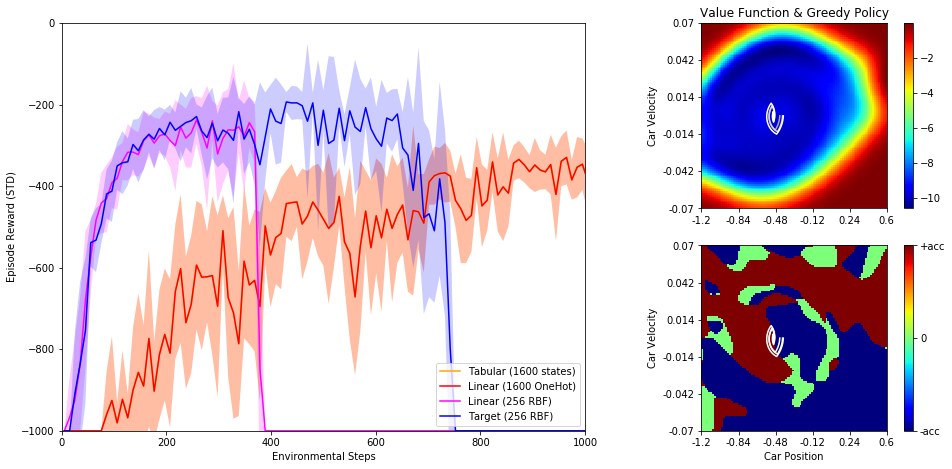

In [12]:
run_experiment(env, TargetQLearner(env, RBF(env, 16)))
plot_all_results(env)

The target networks can stabilise an agent's performance quite a bit, but do not have to. Do you observe more stable learning? Is the behaviour still unstable at the end?

## TASK 3b: double Q-learning
Extend the class TargetQLearner to implement double Q-learning (akin to Double DQN from the lecture).

In [13]:
class DoubleQLearner (TargetQLearner):
    
    def __init__(self, env, basis):
        TargetQLearner.__init__(self, env, basis)
        self.name = "Double (%u %s)" % (basis.num_features, basis.name)

    def update(self, state, action, reward, next_state, done):
        """ The agent 'learns' from the given transition. """
        self._refresh_target()
        # Compute greedy actions at next_state with the current Q-function
        greedy = np.argmax(self.q_values(next_state))
        # Compute TD-error with greedy actions for the target Q-function
        not_done = 0 if done else 1
        td_error = reward + not_done*self.gamma*self.target_q_values(next_state)[greedy] \
                          - self.q_values(state)[action]
        # Gradient descend step
        self.weights[action, :] += self.learn_rate * td_error * self.basis(state)

Now test your above DoubleQLearner with the same RBF bases as above. Double Q-learning should further stabilise the agent's performance. 

----- Start Learning with Double (256 RBF) Q-learning -----
Episode #50 (44450 steps) -- Total reward = -430, epsilon=0.1.
Episode #150 (84986 steps) -- Total reward = -242, epsilon=0.1.
Episode #250 (108743 steps) -- Total reward = -162, epsilon=0.1.
Episode #350 (127384 steps) -- Total reward = -148, epsilon=0.1.
Episode #450 (144723 steps) -- Total reward = -151, epsilon=0.1.
Episode #550 (162847 steps) -- Total reward = -148, epsilon=0.1.
Episode #650 (179240 steps) -- Total reward = -153, epsilon=0.1.
Episode #750 (196354 steps) -- Total reward = -154, epsilon=0.1.
Episode #850 (212497 steps) -- Total reward = -150, epsilon=0.1.
Episode #950 (227996 steps) -- Total reward = -160, epsilon=0.1.


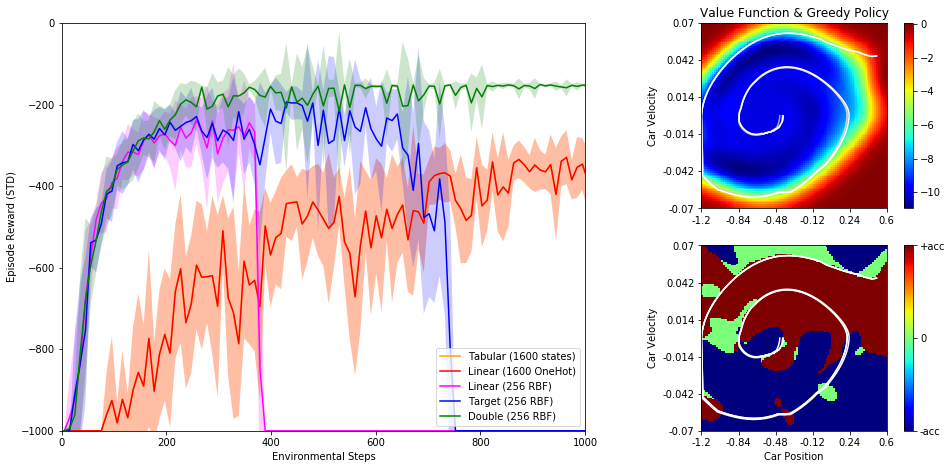

In [14]:
run_experiment(env, DoubleQLearner(env, RBF(env, 16)))
plot_all_results(env)

If you do not have a stable solution by now, increase the number of basis fuctions for each state dimension.
How does the policy look like in comparison to the tabular case in task 1c? Can you formulate an optimal policy for mountain-car based on your observations?

# EXERCISE 4: Deep Q-Networks
In this exercise we will implement Q-learning with a neural network. Read the DQN paper by Mnih et al. https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf for help with the exercise.

## TASK 4a
Implement a deep Q net that holds 10,000 transitions and uses a mini-batch of 32 samples. Make sure that the mini-batch always includes the newest transition.

The following code describes a simple replay buffer which is used to store (state, action, reward, next_state) tuples.

In [61]:
class Replay_buffer():
    def __init__(self, capacity):
        self.buffer = []
        for i in range(capacity):
                self.buffer.append(None)
        self.capacity = capacity
        self.insert_index = 0
        self.num_exp = 0

    def push(self, sarst):
        self.buffer[self.insert_index] = sarst
        self.insert_index = (self.insert_index + 1)%self.capacity
        if self.num_exp < self.capacity:
            self.num_exp += 1

    def sample_buffer(self):
        index = random.randint(0, self.num_exp-1)
        return self.buffer[index]

    def sample_batch(self, size):
        batch = []
        for i in range(size):
            batch.append(self.sample_buffer())
        return batch

Similarly the code-let below describes simple a 3 layer neural network which outputs an action value for all the valid actions in mountaincar.

In [62]:
class Value_Net(torch.nn.Module):
    hidden = 64
    
    def __init__(self):
        super(Value_Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, self.hidden)
        self.fc2 = torch.nn.Linear(self.hidden, self.hidden)
        self.fc2b = torch.nn.Linear(self.hidden, self.hidden)
        self.fc3 = torch.nn.Linear(self.hidden, 3)

    def forward(self, x):
        x = (x - torch.FloatTensor([0, -0.3])) / torch.FloatTensor([0.9, 0.07]) 
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc2b(x))
        #x = torch.tanh(self.fc1(x))
        #x = torch.tanh(self.fc2(x))
        #x = torch.tanh(self.fc2b(x))
        x = self.fc3(x)
        return x

Use the previously defined classes for replay buffer and value network to implement your DQN.

In [63]:
class DQLearner(QLearner):
    buffer_size = 100000
    batch_size = 32
    learning_rate = 1e-3  # 1e-3

    def __init__(self):
        self.name = "DQN"
        self.epsilon = 1.0
        self.qnet = Value_Net()
        self.buffer = Replay_buffer(self.buffer_size)
        self.optimizer = torch.optim.RMSprop(self.qnet.parameters(), lr=self.learning_rate)
        #self.optimizer = torch.optim.RMSprop(self.qnet.parameters())
        self.criterion = torch.nn.MSELoss()

    def q_values(self, state):        
        return self.qnet(torch.Tensor(state))

    def sample(self, state):
        return np.argmax(self.q_values(state).detach().numpy())

    def update(self, state, action, reward, next_state, done):
        obs = {'old': state, 'action': action, 'reward': reward, 'new': next_state, 'done': done}
        self.buffer.push(obs)
        if self.buffer.num_exp < self.batch_size:
            return
        else:
            batch = self.buffer.sample_batch(self.batch_size - 1)
            batch.append(obs)
            states = torch.Tensor(list(map(lambda x: x['old'], batch)))
            actions = torch.LongTensor(list(map(lambda x: x['action'], batch))).unsqueeze(1)
            rewards = torch.Tensor(list(map(lambda x: x['reward'], batch)))
            vals = self.qnet(states).gather(1, actions)
            vals = torch.squeeze(vals)
            targets = torch.zeros(self.batch_size)
            non_terminal_mask = torch.ByteTensor(list(map(lambda x: not x['done'], batch)))
            next_states_nont = torch.Tensor([s['new'] for s in batch if not s['done']])
            targets[non_terminal_mask] = self.qnet(next_states_nont).max(1)[0].detach()
            targets = targets * self.gamma + rewards
            self.optimizer.zero_grad()
            loss = self.criterion(vals, targets)
            loss.backward()
            self.optimizer.step()
            return
    
    def set_epsilon(self, iter):
        """ Exponentially decays the eploration parameter epsilon. """
        self.epsilon = nate**(-iter/250.0)

----- Start Learning with DQN Q-learning -----
Episode #50 (49893 steps) -- Total reward = -1000, epsilon=0.822012.
Episode #150 (149893 steps) -- Total reward = -1000, epsilon=0.551011.
Episode #250 (244960 steps) -- Total reward = -1000, epsilon=0.369354.
Episode #350 (291522 steps) -- Total reward = -308, epsilon=0.247585.
Episode #450 (329468 steps) -- Total reward = -304, epsilon=0.165961.
Episode #550 (377653 steps) -- Total reward = -495, epsilon=0.111247.
Episode #650 (422517 steps) -- Total reward = -894, epsilon=0.0745713.
Episode #750 (473515 steps) -- Total reward = -510, epsilon=0.0499866.
Episode #850 (511989 steps) -- Total reward = -250, epsilon=0.033507.
Episode #950 (551855 steps) -- Total reward = -313, epsilon=0.0224604.


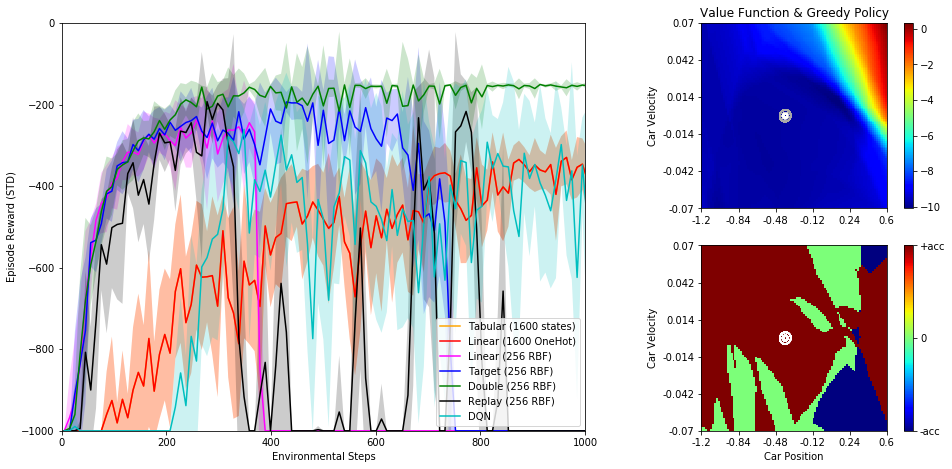

In [64]:
agent =  DQLearner()
for i in range(100):
    run_experiment(env, agent, num_episodes=100)
    plot_all_results(env)

# EXERCISE 5: Improve Q-learning
If you have finished the above tasks and still have some time left, play aound with your solutions to improve performance. In particular, test the following changes for any of the above classes that inherit from LinearQLearner:

## TASK 5a: number of basis function
Plot the performance of the LinearQLearner (and it's descendants) against the number of used RBF basis functions in [10x10, ..., 20x20]. Does an increasing number of bases increase or decrease stability? Note that you need to write your own plotting script.

## TASK 5b: learning rate
Change the implementation of LinearQLearner (and it's descendants) to decrease the learning rate slowly. How does this change affect learning rate and stability? 

## TASK 5c: exploration
The experiment defined in task 1b uses epsilon-greedy exploration with a constant epsilon=0.1. Override the set_epsilon method of (a subclass of) LinearQLearner to implement a decay shedule, which decreases epsilon linearly from 1 to 0.01 in {10, 50, 100, 500} epsiodes. Does this improve the performance or not? What happens with an exponential decay schedule as in DQLearner?

## TASK 5d: DQN variations
There are several things that can be tried out with the DQN. Figure out if using different learning rates, losses and network architecture (number of layers and connectivity) changes the network performance. You can even change the replay buffer implementation to define some heuristic to draw samples from. Explore if these modifications help.

## TASK 5e: scientific evaluation
The experiment defined in task 1b fixes the random seed to ensure reproducability of results. However, each algorithm can behave very different depending on the seed. Run one (or all) above experiment(s) with 10 random seeds (i.e. comment out the lines that set the seed to 0) and plot the mean and staqndard deviation of the received rewards. Note that you may want to write your own plotting script, in which the shaded area refers to another type of standard deviation (between seeds, not over time) than in the given script.

# GRAVEYARD of stuff that simply did not want to work

## [cut?] TASK 3c: experience replay buffers
In this exercise you will further stabilize gradient descent by introducing an experience replay buffer.
Extend the above TargetQLearner with an experience replay buffer, that holds 10,000 transitions and uses a mini-batch of 32 samples. Make sure that the mini-batch always includes the newest transition.

In [20]:
class ReplayQLearner(DoubleQLearner):
    buffer_size = 20000
    mini_batch = 32
    buffer = None

    def __init__(self, env, basis):
        super().__init__(env, basis)
        self.name = "Replay (%u %s)" % (basis.num_features, basis.name)
        self.buffer = []
        # Adjust inherited parameters to work with the higher update rate
        self.learn_rate = self.learn_rate / self.mini_batch
        self.update_target = self.update_target * self.mini_batch

    def insert(self, state, action, reward, next_state, done):
        # Insert the observed transition into the replay buffer
        self.buffer.append((state, action, reward, next_state, done))
        # Always add (at least) the observed transition to the mini-batch
        batch = [(state, action, reward, next_state, done)]
        # Add mini_batch-1 randomly drawn past transitions to the mini-batch
        for _ in range(min(self.mini_batch, len(self.buffer)) - 1):
            # Draw a random transition from the last buffer_size entries of the replay buffer
            i = np.random.randint(max(0, len(self.buffer) - self.buffer_size), len(self.buffer))
            batch.append(self.buffer[i])
        return batch

    def update(self, state, action, reward, next_state, done):
        batch = self.insert(state, action, reward, next_state, done)
        for (s, a, r, ns, d) in batch:
            super().update(s, a, r, ns, d)
            
    def set_epsilon(self, iter):
        """ Maybe we must be random until the buffer is full? """
        self.epsilon = nate**(-iter/250.0)

Now test your ReplayQLearner with the same RBF bases as above. 

*Hint:* depending on the implementation, this experiment may run much longer than those before.

----- Start Learning with Replay (256 RBF) Q-learning -----
Episode #50 (48016 steps) -- Total reward = -771, epsilon=0.822012.
Episode #150 (101867 steps) -- Total reward = -352, epsilon=0.551011.
Episode #250 (133514 steps) -- Total reward = -235, epsilon=0.369354.
Episode #350 (171680 steps) -- Total reward = -1000, epsilon=0.247585.
Episode #450 (261483 steps) -- Total reward = -1000, epsilon=0.165961.
Episode #550 (360992 steps) -- Total reward = -1000, epsilon=0.111247.
Episode #650 (451778 steps) -- Total reward = -1000, epsilon=0.0745713.
Episode #750 (511756 steps) -- Total reward = -169, epsilon=0.0499866.
Episode #850 (578355 steps) -- Total reward = -1000, epsilon=0.033507.
Episode #950 (678355 steps) -- Total reward = -1000, epsilon=0.0224604.


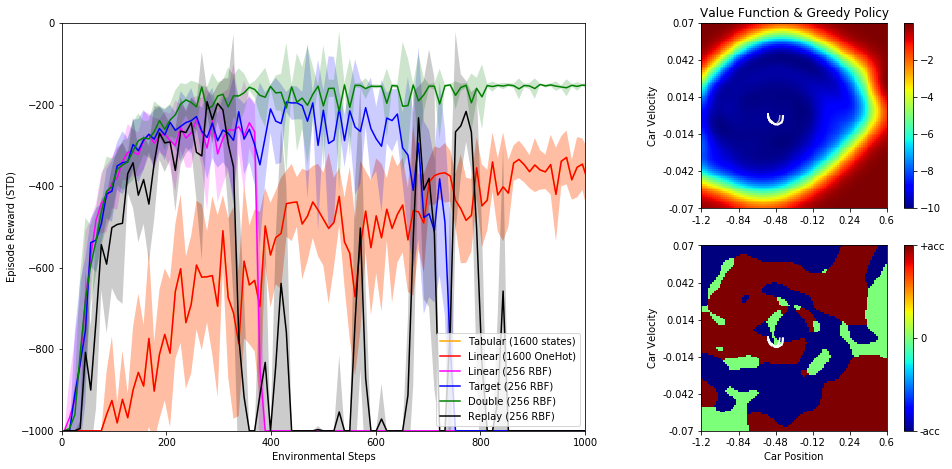

In [21]:
run_experiment(env, ReplayQLearner(env, RBF(env, 16)))
plot_all_results(env)

## TASK 4b 
Extend the deep Q net above with a target network to get stability in performance. Update your target net every 1000 steps and try out different update delays if time permits.

In [ ]:
class Target_DQLearner(DQLearner):
    def __init__(self):
        DQLearner.__init__(self)
        self.name = "Target_DQN"
        self.target_qnet = Value_Net()
        self.target_qnet.load_state_dict(self.qnet.state_dict())
        self.target_qnet.eval()
        self.steps = 0
        self.target_update_delay = 100

    def sample(self, state):
        vals = self.q_values(state)
        self.steps += 1
        return np.argmax(vals.detach().numpy())

    def update(self, state, action, reward, next_state, done):
        obs = {'old': state, 'action': action, 'reward': reward, 'new': next_state, 'done': done}
        self.buffer.push(obs)
        if self.buffer.num_exp < self.batch_size:
            return
        else:
            # Sample a batch of transitions (which includes the currently observed)
            batch = self.buffer.sample_batch(self.batch_size - 1)
            batch.append(obs)
            # Convert batch in Tensors
            states = torch.Tensor(list(map(lambda x: x['old'], batch)))
            actions = torch.LongTensor(list(map(lambda x: x['action'], batch))).unsqueeze(1)
            rewards = torch.Tensor(list(map(lambda x: x['reward'], batch)))
            # Compute the values at the start states
            vals = self.qnet(states).gather(1, actions)
            vals = torch.squeeze(vals)
            # Collect the non-terminal next states
            non_terminal_mask = torch.ByteTensor(list(map(lambda x: not x['done'], batch)))
            next_states_nont = torch.Tensor([s['new'] for s in batch if not s['done']])
            # Compute the greedy action at the next state
            greedy = self.qnet(next_states_nont).max(dim=1)[1]
            # Compute the regression targets (gamma times target values at next state plus reward)
            targets = torch.zeros(self.batch_size)
            print(self.target_qnet(next_states_nont).shape, greedy.shape)
            targets[non_terminal_mask] = self.target_qnet(next_states_nont).gather(dim=1, index=greedy).detach()
            targets = targets * self.gamma + rewards
            # Run backpropagation on the loss between values and targets
            self.optimizer.zero_grad()
            loss = self.criterion(vals, targets)
            loss.backward()
            self.optimizer.step()
            # Update target network
            if self.steps % self.target_update_delay == 0:
                self.target_qnet.load_state_dict(self.qnet.state_dict())
            return

In [ ]:
run_experiment(env, Target_DQLearner())
plot_all_results(env)